In [1]:
%matplotlib inline

In [2]:
import  os
import  sys
import  glob

In [3]:
import  pdfkit
import  fitsio
import  redrock
import  datetime
import  redrock.templates

import  pandas                  as      pd
import  pylab                   as      pl
import  numpy                   as      np
import  matplotlib.pyplot       as      plt
import  astropy.io.fits         as      fits
import  matplotlib.pyplot       as      plt
import  astropy.io.fits         as      fits

from    astropy.table           import  Table, join, vstack, unique
from    astropy.coordinates     import  SkyCoord
from    astropy                 import  units as u
from    desitarget.cmx          import  cmx_targetmask
from    desitarget.targets      import  desi_mask, bgs_mask, mws_mask
from    desispec.interpolation  import  resample_flux
from    desispec.resolution     import  Resolution
from    desispec.specscore      import  compute_frame_scores
from    collections             import  OrderedDict
from    mpl_toolkits.axes_grid1 import  make_axes_locatable
from    itertools               import  combinations
from    desisurvey.utils        import  get_date

In [14]:
# /global/homes/m/mjwilson/BGS/MINISV/zhou
version = 'v2'
root    = '/global/cscratch1/sd/mjwilson/BGS/MINISV/coadds/{}/'.format(version)

##  Aaron's GFA Telemetry

In [4]:
file      = fits.open('/global/cfs/cdirs/desi/users/ameisner/GFA/minisv2/gfa_reduce_ccds_minisv2-thru_20200304.fits')
# file[1].header

In [5]:
# Takes a while for NIGHT computation.
telemetry = Table(file[1].data)  
original  = telemetry.columns

keep_cols = ['CAMERA', 'EXPID', 'MJD', 'PROGRAM', 'SKY_MAG_AB', 'PETAL_LOC',\
             'MOONRA', 'MOONDEC', 'AIRMASS', 'FIBER_FRACFLUX',\
             'MOON_SEP_DEG', 'TRANSPARENCY', 'FWHM_ASEC']

# telemetry = telemetry[keep_cols]

# telemetry.sort('PETAL_LOC')
telemetry

MEDIAN,MEAN,N_NON_FINITE,MAX,MIN,SIG_ROBUST,SIG,MEDIAN_Q1,MEAN_Q1,N_NON_FINITE_Q1,MAX_Q1,MIN_Q1,SIG_ROBUST_Q1,SIG_Q1,MEDIAN_Q2,MEAN_Q2,N_NON_FINITE_Q2,MAX_Q2,MIN_Q2,SIG_ROBUST_Q2,SIG_Q2,MEDIAN_Q3,MEAN_Q3,N_NON_FINITE_Q3,MAX_Q3,MIN_Q3,SIG_ROBUST_Q3,SIG_Q3,MEDIAN_Q4,MEAN_Q4,N_NON_FINITE_Q4,MAX_Q4,MIN_Q4,SIG_ROBUST_Q4,SIG_Q4,CAMERA,SKY_MAG_AB,SKY_MAG_AB_PER_AMP [4],PETAL_LOC,EXPID,MJD,PROGRAM,SKYRA,SKYDEC,DOMSHUTL,DOMSHUTU,PMCOVER,MOONRA,MOONDEC,T_C_FOR_DARK,T_C_FOR_DARK_IS_GUESS,TIME_S_FOR_DARK,AIRMASS,NIGHT,FOCUS,EXPTIME,CUBE_INDEX,RACEN,DECCEN,FNAME_RAW,GITREV,EXTNAME,CONTRAST,FIBER_FRACFLUX,N_SOURCES_FOR_PSF,APER_CORR_FAC,XCENTROID_PSF,YCENTROID_PSF,MOON_SEP_DEG,ZP_ADU_PER_S,TRANSPARENCY,NPIX_BAD_TOTAL,NPIX_BAD_PER_AMP [4],OVERSCAN_MEDIANS_ADU [4],PRESCAN_MEDIANS_ADU [4],FWHM_MAJOR_PIX,FWHM_MINOR_PIX,FWHM_PIX,FWHM_ASEC,N_SOURCES,NAXIS [2],"CD [2,2]",CDELT [2],CRPIX [2],CRVAL [2],CTYPE [2],LONGPOLE,LATPOLE,PV2 [2],FNAME_MASTER_DARK,DO_FIT_DARK_SCALING,MASTER_DARK_EXPTIME,MASTER_DARK_GCCDTEMP,DARK_TEMP_SCALING_FACTOR,TOTAL_DARK_SCALING_FACTOR,DARK_RESCALE_FACTORS_PER_AMP [4],DARK_RESCALE_FACTOR_BESTFIT,DARK_RESCALE_FACTOR_ADOPTED,APPLY_DARK_RESCALE_FACTOR,DARK_RESCALE_NCALLS [4],DARK_RESCALE_CONVERGED [4]
float64,float64,int64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,str6,float64,float32,uint8,int64,float64,str94,float64,float64,str8,str8,str4,float64,float64,float64,int64,float64,float64,int64,str37,float64,int64,float64,float64,str97,str7,str6,float64,float64,int64,float64,float64,float64,float64,float64,float64,int64,int64,float32,float32,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,str8,float64,float64,float64,str114,uint8,float64,float64,float64,float64,float64,float64,float64,uint8,int64,uint8
1712.0,1725.098036182019,0,40297.0,1558.0,50.40847542919047,50.40847542919047,1723.0,1738.676263853561,0,19942.0,1595.0,48.92587321068487,48.92587321068487,1670.0,1685.548578306686,0,40297.0,1558.0,37.06505546264005,37.06505546264005,1713.0,1728.5348685804263,0,36932.0,1607.0,41.51286211815686,41.51286211815686,1733.0,1747.6324339874031,0,32441.0,1616.0,44.47806655516806,44.47806655516806,GUIDE0,21.278239609429775,21.311693 .. 21.263325,0,50986,58899.13338673,system test,105.00378,38.000781,open,open,open,293.097195,-23.012979,10.805,0,15.0,1.044303,20200219,"897.3,-549.8,27.5,-0.9,14.3,0.0",15.0,0,104.487796764084,36.46902917158815,/project/projectdirs/desi/spectro/data/20200219/00050986/guide-00050986.fits.fz,1f12aa8,GUIDE0,19.226427349944906,0.5688880299256625,46,0.9029743560324699,25.00828606704136,25.11117388860352,164.624366038092,25.62602948276017,0.94569036749243,0,0 .. 0,1432.0 .. 1394.0,1418.0 .. 1384.0,5.7282788968856595,4.944645517172254,5.32205867767334,1.0910220289230346,103,2048 .. 1032,-5.64158190288e-05 .. 5.1670258812e-05,1.0 .. 1.0,2488.938096826881 .. 29633.401438347595,105.00378 .. 38.000781,RA---TAN .. DEC--TAN,180.0,90.0,0.0 .. 0.0,/project/projectdirs/desi/users/ameisner/GFA/gfa_reduce_etc/master_dark_library/master_dark-00041168_00041237.fits,1,15.0,11.074,0.9409868352447903,14.400492886005727,1.0195446777343748 .. 1.0183801269531252,1.020240478515625,1.020240478515625,1,37 .. 41,1 .. 1
1527.0,1505.677508686864,0,34146.0,1262.0,99.33434863987533,99.33434863987533,1553.0,1557.5716013353924,0,15625.0,1465.0,16.308624403561623,16.308624403561623,1487.0,1492.4405413487161,0,32814.0,1384.0,16.308624403561623,16.308624403561623,1617.0,1625.431033112282,0,34146.0,1532.0,17.791226622067224,17.791226622067224,1341.0,1347.2668589510658,0,28037.0,1262.0,17.791226622067224,17.791226622067224,GUIDE2,21.1566682535317,21.167545 .. 21.158138,2,50986,58899.13338672,system test,105.00378,38.000781,open,open,open,293.097195,-23.012979,10.767,0,15.0,1.044303,20200219,"897.3,-549.8,27.5,-0.9,14.

In [6]:
uprogs, cnts = np.unique(telemetry['PROGRAM'], return_counts=True)

progs2keep   = ['MW tile 70500',\
                'MW tile 70510',\
                'MW+BGS tile 70500 (1 of 2)',\
                'MW/BGS tile 70502 (1 of 2)',\
                'MW/BGS tile 70510',\
                'MW/BGS tile 70510 (1 of 2)',\
                'SV tile 70502',\
               ]

keep         = [x.strip() in progs2keep for x in telemetry['PROGRAM']]

for i, x in enumerate(uprogs):
  this       = np.array(telemetry['PROGRAM'])[keep]   

  if np.any(this == x):      
    print('{:2d}  {} {} \t {}'.format(i, repr(x), cnts[i], np.any(this == x)))
    
  else:    
    print('{:2d}  {} {} \t \t {}'.format(i, repr(x), cnts[i], np.any(this == x)))

 0  'Commissioning                                                                                 ' 222 	 	 False
 1  'Dither fibermode tile 63159 (106.34, 31.89)                                                   ' 144 	 	 False
 2  'Dither fibermode tile 63160 (106.34, 31.89)                                                   ' 144 	 	 False
 3  'Dither fibermode tile 63161 (106.34, 31.89)                                                   ' 144 	 	 False
 4  'Dither fibermode tile 63162 (106.34, 31.89)                                                   ' 144 	 	 False
 5  'Dither fibermode tile 63163 (106.34, 31.89)                                                   ' 144 	 	 False
 6  'Dither fibermode tile 63164 (106.34, 31.89)                                                   ' 144 	 	 False
 7  'Dither fibermode tile 63165 (106.34, 31.89)                                                   ' 144 	 	 False
 8  'Dither fibermode tile 63166 (106.34, 31.89)                                

In [8]:
bgs_telemetry = telemetry[keep]
bgs_telemetry

MEDIAN,MEAN,N_NON_FINITE,MAX,MIN,SIG_ROBUST,SIG,MEDIAN_Q1,MEAN_Q1,N_NON_FINITE_Q1,MAX_Q1,MIN_Q1,SIG_ROBUST_Q1,SIG_Q1,MEDIAN_Q2,MEAN_Q2,N_NON_FINITE_Q2,MAX_Q2,MIN_Q2,SIG_ROBUST_Q2,SIG_Q2,MEDIAN_Q3,MEAN_Q3,N_NON_FINITE_Q3,MAX_Q3,MIN_Q3,SIG_ROBUST_Q3,SIG_Q3,MEDIAN_Q4,MEAN_Q4,N_NON_FINITE_Q4,MAX_Q4,MIN_Q4,SIG_ROBUST_Q4,SIG_Q4,CAMERA,SKY_MAG_AB,SKY_MAG_AB_PER_AMP [4],PETAL_LOC,EXPID,MJD,PROGRAM,SKYRA,SKYDEC,DOMSHUTL,DOMSHUTU,PMCOVER,MOONRA,MOONDEC,T_C_FOR_DARK,T_C_FOR_DARK_IS_GUESS,TIME_S_FOR_DARK,AIRMASS,NIGHT,FOCUS,EXPTIME,CUBE_INDEX,RACEN,DECCEN,FNAME_RAW,GITREV,EXTNAME,CONTRAST,FIBER_FRACFLUX,N_SOURCES_FOR_PSF,APER_CORR_FAC,XCENTROID_PSF,YCENTROID_PSF,MOON_SEP_DEG,ZP_ADU_PER_S,TRANSPARENCY,NPIX_BAD_TOTAL,NPIX_BAD_PER_AMP [4],OVERSCAN_MEDIANS_ADU [4],PRESCAN_MEDIANS_ADU [4],FWHM_MAJOR_PIX,FWHM_MINOR_PIX,FWHM_PIX,FWHM_ASEC,N_SOURCES,NAXIS [2],"CD [2,2]",CDELT [2],CRPIX [2],CRVAL [2],CTYPE [2],LONGPOLE,LATPOLE,PV2 [2],FNAME_MASTER_DARK,DO_FIT_DARK_SCALING,MASTER_DARK_EXPTIME,MASTER_DARK_GCCDTEMP,DARK_TEMP_SCALING_FACTOR,TOTAL_DARK_SCALING_FACTOR,DARK_RESCALE_FACTORS_PER_AMP [4],DARK_RESCALE_FACTOR_BESTFIT,DARK_RESCALE_FACTOR_ADOPTED,APPLY_DARK_RESCALE_FACTOR,DARK_RESCALE_NCALLS [4],DARK_RESCALE_CONVERGED [4]
float64,float64,int64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,str6,float64,float32,uint8,int64,float64,str94,float64,float64,str8,str8,str4,float64,float64,float64,int64,float64,float64,int64,str37,float64,int64,float64,float64,str97,str7,str6,float64,float64,int64,float64,float64,float64,float64,float64,float64,int64,int64,float32,float32,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,str8,float64,float64,float64,str114,uint8,float64,float64,float64,float64,float64,float64,float64,uint8,int64,uint8
1684.0,1693.462463852047,0,32392.0,1541.0,44.47806655516806,44.47806655516806,1695.0,1706.4587875484497,0,11531.0,1574.0,42.99546433666246,42.99546433666246,1643.0,1654.2313412215358,0,22821.0,1541.0,32.61724880712325,32.61724880712325,1686.0,1698.5380178052326,0,23036.0,1582.0,37.06505546264005,37.06505546264005,1702.0,1714.62170883297,0,32392.0,1597.0,40.030259899651256,40.030259899651256,GUIDE0,21.006675233518607,21.017637 .. 21.016413,0,52090,58905.25448622,SV tile 70502,180.012,-0.510261,not open,open,open,6.887381,-2.523766,9.678,0,15.0,1.663456,20200225,"617.4,-264.2,1076.3,-18.4,-2.1,0.0",15.0,0,179.58462698957734,-2.031037823124222,/project/projectdirs/desi/spectro/data/20200225/00052090/guide-00052090.fits.fz,1f12aa8,GUIDE0,3.8204875294661815,0.09543107532242492,6,0.33568707637040507,26.011779427199414,25.280014697547998,171.3949218890838,25.40374320807157,0.8223710859427306,0,0 .. 0,1434.0 .. 1395.0,1419.0 .. 1384.0,24.78859683568296,12.59709429145485,17.671001434326172,3.622555294036865,18,2048 .. 1032,-5.64158190288e-05 .. 5.1670258812e-05,1.0 .. 1.0,2241.951981159889 .. 29530.036653755775,180.012 .. -0.510261,RA---TAN .. DEC--TAN,180.0,90.0,0.0 .. 0.0,/project/projectdirs/desi/users/ameisner/GFA/gfa_reduce_etc/master_dark_library/master_dark-00034652_00034751.fits,1,15.0,9.918,0.9294595855618852,14.560446187674744,1.0384375000000001 .. 1.0432012939453128,1.0443664550781253,1.0443664550781253,1,27 .. 41,1 .. 1
1503.0,1480.81327358512,0,32781.0,1251.0,103.78215529539214,103.78215529539214,1526.0,1528.935664213905,0,14813.0,1433.0,14.82602218505602,14.82602218505602,1463.0,1468.0797317859738,0,32781.0,1345.0,14.82602218505602,14.82602218505602,1598.0,1601.1597777374031,0,21055.0,1531.0,16.308624403561623,16.308624403561623,1321.0,1325.0779206031978,0,25193.0,1251.0,16.308624403561623,16.308624403561623,GUIDE2,21.130802625301424,21.133589 .. 21.107409,2,52090,58905.25448622,SV tile 70502,180.012,-0.510261,not open,open,open,6.887381,-2.523766,9.739,0,15.0,1.663456,20200225,"617.4,-264.2,10

In [9]:
##  Basic quality cut on N source used to establish e.g. PSF
gold_bgs_telemetry = bgs_telemetry[bgs_telemetry['N_SOURCES_FOR_PSF'] > 2]

##   
len(gold_bgs_telemetry), len(bgs_telemetry)

(13481, 17400)

0.007681646843835425 1.9931007321734477


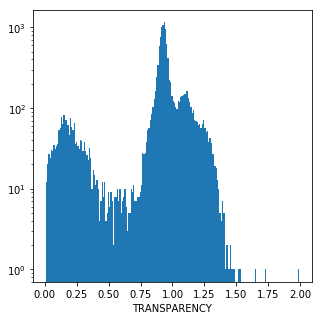

In [10]:
fig, axes   = plt.subplots(1, figsize=(5, 5))

max_trans   = gold_bgs_telemetry['TRANSPARENCY'][~np.isnan(gold_bgs_telemetry['TRANSPARENCY'])].max()
min_trans   = gold_bgs_telemetry['TRANSPARENCY'][~np.isnan(gold_bgs_telemetry['TRANSPARENCY'])].min()

print(min_trans, max_trans)

_           = pl.hist(gold_bgs_telemetry['TRANSPARENCY'][~np.isnan(gold_bgs_telemetry['TRANSPARENCY'])], bins=200)

pl.xlabel('TRANSPARENCY')
pl.yscale('log')

In [11]:
uexpids   = np.unique(bgs_telemetry['EXPID'])

In [12]:
#  Average over petals and available sub-exposures (MJD).
first_exp = bgs_telemetry[(bgs_telemetry['EXPID'] == uexpids[0])]

keys      = bgs_telemetry.keys()
keys.sort()
keys      = list(keys)

for key in keys:
  if  np.all(first_exp[key][:] == first_exp[key][0]):   
    print('{} \t {}'.format(key.ljust(25), True))
    
  else:
    print('{} \t \t {} \t \t {}'.format(key.ljust(25), False, len(np.unique(first_exp[key][:]))))

AIRMASS                   	 True
APER_CORR_FAC             	 	 False 	 	 642
APPLY_DARK_RESCALE_FACTOR 	 True
CAMERA                    	 	 False 	 	 6
CD                        	 	 False 	 	 24
CDELT                     	 True
CONTRAST                  	 	 False 	 	 632
CRPIX                     	 	 False 	 	 1158
CRVAL                     	 True
CTYPE                     	 True
CUBE_INDEX                	 	 False 	 	 107
DARK_RESCALE_CONVERGED    	 True
DARK_RESCALE_FACTORS_PER_AMP 	 	 False 	 	 2310
DARK_RESCALE_FACTOR_ADOPTED 	 	 False 	 	 638
DARK_RESCALE_FACTOR_BESTFIT 	 	 False 	 	 638
DARK_RESCALE_NCALLS       	 	 False 	 	 36
DARK_TEMP_SCALING_FACTOR  	 	 False 	 	 74
DECCEN                    	 	 False 	 	 637
DOMSHUTL                  	 True
DOMSHUTU                  	 True
DO_FIT_DARK_SCALING       	 True
EXPID                     	 True
EXPTIME                   	 	 False 	 	 2
EXTNAME                   	 	 False 	 	 6
FIBER_FRACFLUX            	 	 False 	 	 642
FNAME_MAST

##  Rongpu cframe Table 

In [15]:
cpath      = '/global/homes/m/mjwilson/BGS/MINISV/zhou/bgs_allcframes_{}.fits'.format(version)
cframes    = Table(fits.open(cpath)[1].data)

del  cframes['cframe']

cols       = list(cframes.columns)

for x in cols:
  cframes.rename_column(x, x.upper())

keep       = (cframes['CAMERA'] == 'b') & (cframes['PETAL_LOC'] == 0) 
cframes    =  cframes[keep]

uids, cnts =  np.unique(cframes['EXPID'], return_counts=True)

assert  cnts.max() == 1

cframes.sort('MJD')
cframes

NIGHT,MJD,LAT,LON,ELV,TILEID,EXPID,EXPTIME,CAMERA,PROGRAM,PETAL_LOC,SPECGRPH,RA,DEC,MOON_ALT,MOON_RA,MOON_DEC,MOON_FRAC,MOON_SEP,SUN_ALT,SUN_RA,SUN_DEC,SUN_SEP,AIRMASS,EBV
str40,float64,float64,float64,float64,int64,int64,float64,str40,str40,int32,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
20200225,58905.25690431,31.96403,-111.59989,2097.0,70502,52090,900.0,b,SV tile 70502,0,0,180.012,-0.510261,-34.718022305904064,6.5807533473741975,-2.8514428140522536,0.0627905403740725,172.62306614298288,-58.985404389203396,338.8184557889157,-8.90282836156349,156.88472549965033,1.6491293775976599,0.031056919357460633
20200225,58905.29573492,31.96403,-111.59989,2097.0,70502,52112,900.0,b,SV tile 70502,0,0,180.006929,-0.50838,-44.78323495364497,7.13291666046073,-2.6659189741928837,0.06456711009394417,172.20097121173714,-65.64763237733636,338.8556693565404,-8.888320131591259,156.92963241839925,1.369023183589419,0.0312053262371375
20200225,58905.31193004,31.96403,-111.59989,2097.0,70502,52113,900.0,b,SV tile 70502,0,0,180.005321,-0.50784,-48.586919491100886,7.370943062741406,-2.5891783616882074,0.06531494808352112,172.01171055181683,-66.79677755424515,338.8711961359056,-8.882273781256869,156.94780316155754,1.2994305476825312,0.031253747139170805
20200225,58905.32773044,31.96403,-111.59989,2097.0,70502,52114,900.0,b,SV tile 70502,0,0,180.00393,-0.507439,-51.96852565860669,7.606736835371001,-2.514662250166344,0.06604845305372314,171.82047712124663,-66.72988951170322,338.8863448289446,-8.876377467093185,156.96531649871432,1.2500622958528522,0.03129685304110389
20200225,58905.34240863,31.96403,-111.59989,2097.0,70502,52115,900.0,b,SV tile 70502,0,0,180.002758,-0.50717,-54.73305155535852,7.828428021115093,-2.4457432197366633,0.0667333011269644,171.63760278372388,-65.62130882827513,338.9004160743998,-8.870902290343162,156.9814314957455,1.2179571464987913,0.03133440790266168
20200225,58905.35785641,31.96403,-111.59989,2097.0,70502,52116,900.0,b,SV tile 70502,0,0,180.00163,-0.506989,-57.14471621920915,8.063946719361258,-2.3735153579790715,0.06745762823660251,171.44036915108612,-63.508533242504264,338.91522163835987,-8.865142463156191,156.99824918477057,1.1967426672462942,0.03137193973175106
20200227,58907.38710085,31.96403,-111.59989,2097.0,70502,52447,500.0,b,MW/BGS tile 70502 (1 of 2),0,0,179.999229,-0.50693,-44.5709697497139,30.051688879907612,6.92091382538617,0.19181133310720833,149.34946356612664,-56.96464169683635,340.8290572726072,-8.103346848212203,159.04038863424637,1.1916720198371635,0.031457665975618346
20200227,58907.39358829,31.96403,-111.59989,2097.0,70502,52448,500.0,b,MW/BGS tile 70502 (2 of 2),0,0,179.999229,-0.50693,-45.61385767370481,30.15124505274347,6.948272228964209,0.192293202118483,149.24725982734384,-55.430239699792985,340.83523698883977,-8.10090311045813,159.04697410482876,1.1971309375018842,0.031457665975618346
20200228,58908.18319769,31.96403,-111.59989,2097.0,70500,52630,500.0,b,MW tile 70500,0,0,119.001779,50.00322,18.89320482922571,38.5427621691043,10.533205321961276,0.2543762544024462,75.83085748577656,-38.74253368941566,341.5746822133059,-7.802289556799742,124.95588876434323,1.0553559056837631,0.050803485029043874


In [39]:
# toprint = cframes['NIGHT', 'MJD', 'EXPID', 'TRANSPARENCY', 'MOON_RA', 'MOONRA', 'MOON_DEC', 'MOONDEC', 'MOON_SEP', 'MOON_SEP_DEG']
# toprint.pprint(max_lines=-1, max_width=-1)

##  Join with GFA.

In [24]:
mean = Table()
row  = Table()

keys = list(bgs_telemetry.columns)

for i, _ in enumerate(cframes):
  spec_start = _['MJD']
  spec_end   = _['MJD'] + _['EXPTIME'] / 86400.

  isin       = (spec_start <= bgs_telemetry['MJD']) & (bgs_telemetry['MJD'] < spec_end)
 
  this_exp   = bgs_telemetry[isin]

  for key in keys:
    try:
      if key in ['EXPID', 'NIGHT', 'TILE']:
        row[key] = _[key]
        
      else:
        row[key] = np.atleast_1d(np.median(this_exp[key][~np.isnan(this_exp[key])]))
        
    except:
      if i == 0:
        print('\tFailed to add {} \t {} \t {}.'.format(key.ljust(15), 0.0, str(this_exp[key].dtype)))  
 
  mean = vstack((row, mean))

print('\n\n')
    
mean.sort('MJD')

# toprint = mean['NIGHT', 'MJD', 'EXPID', 'TRANSPARENCY', 'AIRMASS']
# toprint.pprint(max_lines=-1)

keep = ['EXPID'] + [x for x in mean.columns if x not in cframes.columns]

mean = join(cframes, mean[keep], join_type='left', keys='EXPID')

	Failed to add CAMERA          	 0.0 	 <U6.
	Failed to add PROGRAM         	 0.0 	 <U94.
	Failed to add DOMSHUTL        	 0.0 	 <U8.
	Failed to add DOMSHUTU        	 0.0 	 <U8.
	Failed to add PMCOVER         	 0.0 	 <U4.
	Failed to add FOCUS           	 0.0 	 <U37.
	Failed to add FNAME_RAW       	 0.0 	 <U97.
	Failed to add GITREV          	 0.0 	 <U7.
	Failed to add EXTNAME         	 0.0 	 <U6.
	Failed to add CTYPE           	 0.0 	 <U8.
	Failed to add FNAME_MASTER_DARK 	 0.0 	 <U114.





In [25]:
mpath      = '/global/homes/m/mjwilson/BGS/MINISV/zhou/bgs_allcframes_{}_gfa.fits'.format(version)
mean.write(mpath, format='fits', overwrite=True)

##  Done.